# Example 2: HKR classifier on toy dataset

In this notebook, we show how to build a robust classifier based on the regularized
version of the Kantorovitch-Rubinstein duality. We use the `two moons` synthetic dataset
for our experiments.


## 1. Two moons dataset

We first build our two moons dataset.

In [1]:
from sklearn.datasets import make_moons, make_circles  # the synthetic dataset

circle_or_moons = 1  # 0 for circle, 1 for moons
n_samples = 5000  # number of sample in the dataset
noise = 0.05  # amount of noise to add in the data. Tested with 0.14 for circles 0.05 for two moons
factor = 0.4  # scale factor between the inner and the outer circle

In [2]:
if circle_or_moons == 0:
    X, Y = make_circles(n_samples=n_samples, noise=noise, factor=factor)
else:
    X, Y = make_moons(n_samples=n_samples, noise=noise)

# When working with the HKR-classifier, using labels {-1, 1} instead of {0, 1} is advised.
# This will be explained later on.
Y[Y == 1] = -1
Y[Y == 0] = 1

<AxesSubplot:>

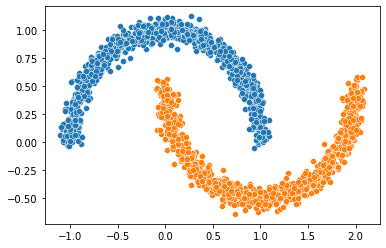

In [3]:
import seaborn as sns

X1 = X[Y == 1]
X2 = X[Y == -1]
sns.scatterplot(x=X1[:1000, 0], y=X1[:1000, 1])
sns.scatterplot(x=X2[:1000, 0], y=X2[:1000, 1])

## 2. Relation with optimal transport

In this setup we can solve the optimal transport problem between the distribution of
`X[Y==1]` and `X[Y==-1]`. This usually requires to match each element of the first
distribution with an element of the second distribution such that this minimizes a
global cost. In our setup this cost is the $L_1$ distance, which will allow us to make
use of the KR dual formulation. The overall cost is then the $W_1$ distance.

### 2.1. Wasserstein distance

The wasserstein distance measures the distance between two probability distributions.
The Wikipedia article gives a more intuitive definition of it:

> Intuitively, if each distribution is viewed as a unit amount of "dirt" piled on $M$,
> the metric is the minimum "cost" of turning one pile into the other, which is assumed
> to be the amount of dirt that needs to be moved times the mean distance it has to be
> moved. Because of this analogy, the metric is known in computer science as the earth
> mover's distance.

Mathematically it is defined as

$$
W_1(\mu, \nu) = \inf_{\pi \in \Pi(\mu,\nu)} \underset{x, z \sim \pi}{\mathbb{E}} \Vert{} \textbf{x}-\textbf{z} \Vert{}
$$

where $\Pi(\mu,\nu)$ is the set of all probability measures on $\Omega\times \Omega$
with marginals $\mu$ and $\nu$. In most cases, this equation is not tractable.

### 2.2. KR dual formulation

The Kantorovich-Rubinstein (KR) dual formulation of the Wasserstein distance is

$$
W_1(\mu, \nu) = \sup_{f \in Lip_1(\Omega)} \underset{\textbf{x} \sim \mu}{\mathbb{E}}
\left[f(\textbf{x} )\right] -\underset{\textbf{x} \sim \nu}{\mathbb{E}}
\left[f(\textbf{x} )\right].
$$

This states the problem as an optimization problem over the space of 1-Lipschitz
functions. We can estimate this by optimizing over the space of 1-Lipschitz neural
networks.

### 2.3. Hinge-KR loss

When dealing with $W_1$, we usually try to optimize the maximization problem above
without taking into account the actual classification task at hand. To improve
robustness for our task, we want our classifier $F$ to be centered in 0, which can be
done without altering the inital problem and its Lipschitz property. By doing so we can
use the obtained function for binary classification, by looking at the sign of $F$.

In order to enforce this, we will add a Hinge term to the loss. It has been shown that
this new problem is still a optimal transport problem and that this problem admit a
meaningfull optimal solution.

### 2.4. HKR classifier

Now we will show how to build a binary classifier based on the regularized version of
the KR dual problem.

In order to ensure the 1-Lipschitz constraint, `torchlip` uses spectral normalization.
These layers can also use Björk orthonormalization to ensure that the gradient of the
layer is 1 almost everywhere. Experiment shows that the optimal solution lies in this
sub-class of functions.


In [4]:
import torch
from deel import torchlip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Other Lipschitz activations are ReLU, MaxMin, GroupSort2, GroupSort.
wass = torchlip.Sequential(
    torchlip.SpectralLinear(2, 256),
    torchlip.FullSort(),
    torchlip.SpectralLinear(256, 128),
    torchlip.FullSort(),
    torchlip.SpectralLinear(128, 64),
    torchlip.FullSort(),
    torchlip.FrobeniusLinear(64, 1),
).to(device)

wass

Sequential(
  (0): SpectralLinear(in_features=2, out_features=256, bias=True)
  (1): FullSort()
  (2): SpectralLinear(in_features=256, out_features=128, bias=True)
  (3): FullSort()
  (4): SpectralLinear(in_features=128, out_features=64, bias=True)
  (5): FullSort()
  (6): FrobeniusLinear(in_features=64, out_features=1, bias=True)
)

As we can see, the network has a gradient equal to 1 almost everywhere as all the layers
respect this property.

It is good to note that the last layer is a `FrobeniusLinear` because, with a single
output, it becomes equivalent to normalize the Frobenius norm and the spectral norm (as
we only have a single singular value).


### 2.5. Learn classification on toy dataset

Now we are ready to learn the classification task on the two moons dataset.

In [5]:
from deel.torchlip.functional import kr_loss, hkr_loss, hinge_margin_loss
from tqdm import tqdm

batch_size = 256
n_epochs = 10

alpha = 10
min_margin = 0.29  # minimum margin to enforce between the values of F for each class

optimizer = torch.optim.Adam(lr=0.01, params=wass.parameters())

loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(X).float(), torch.tensor(Y).float()),
    batch_size=batch_size,
    shuffle=True,
)

for epoch in range(n_epochs):

    # print(f"Epoch {epoch + 1}/{n_epochs}")
    m_kr, m_hm, m_acc = 0, 0, 0

    print(f"Epoch {epoch + 1}/{n_epochs}")
    tsteps = tqdm(loader)

    for step, (data, target) in enumerate(tsteps):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = wass(data)
        loss = hkr_loss(output, target, alpha=alpha, min_margin=min_margin)
        loss.backward()
        optimizer.step()

        m_kr += kr_loss(output, target, (1, -1))
        m_hm += hinge_margin_loss(output, target, min_margin)
        m_acc += (
            torch.sign(output.view(target.shape)) == torch.sign(target)
        ).sum() / len(target)

        tsteps.set_postfix(
            {
                k: "{:.04f}".format(v)
                for k, v in {
                    "loss": loss,
                    "kr": m_kr / (step + 1),
                    "hinge": m_hm / (step + 1),
                    "acc": m_acc / (step + 1),
                }.items()
            }
        )


Epoch 1/10


100%|██████████| 20/20 [00:00<00:00, 70.96it/s, loss=1.0798, kr=0.1217, hinge=0.2323, acc=0.6038]


Epoch 2/10


100%|██████████| 20/20 [00:00<00:00, 71.72it/s, loss=-0.5668, kr=0.6661, hinge=0.0731, acc=0.8917]


Epoch 3/10


100%|██████████| 20/20 [00:00<00:00, 73.99it/s, loss=-0.3509, kr=0.9443, hinge=0.0469, acc=0.9228]


Epoch 4/10


100%|██████████| 20/20 [00:00<00:00, 74.78it/s, loss=-0.7228, kr=0.9387, hinge=0.0302, acc=0.9626]


Epoch 5/10


100%|██████████| 20/20 [00:00<00:00, 74.15it/s, loss=-0.6116, kr=0.9591, hinge=0.0294, acc=0.9651]


Epoch 6/10


100%|██████████| 20/20 [00:00<00:00, 73.97it/s, loss=-0.8464, kr=0.9271, hinge=0.0193, acc=0.9852]


Epoch 7/10


100%|██████████| 20/20 [00:00<00:00, 73.60it/s, loss=-0.8712, kr=0.9557, hinge=0.0206, acc=0.9801]


Epoch 8/10


100%|██████████| 20/20 [00:00<00:00, 73.88it/s, loss=-0.7564, kr=0.9617, hinge=0.0212, acc=0.9805]


Epoch 9/10


100%|██████████| 20/20 [00:00<00:00, 74.63it/s, loss=-0.7848, kr=0.9764, hinge=0.0235, acc=0.9743]


Epoch 10/10


100%|██████████| 20/20 [00:00<00:00, 74.53it/s, loss=-0.7238, kr=0.9554, hinge=0.0186, acc=0.9862]


### 2.6. Plot output countour line

As we can see, the classifier gets a pretty good accuracy. We now look at the actual
function. Since we are in a two-dimensional space, we can draw a countour plot to
visualize $F$.


<a list of 5 text.Text objects>

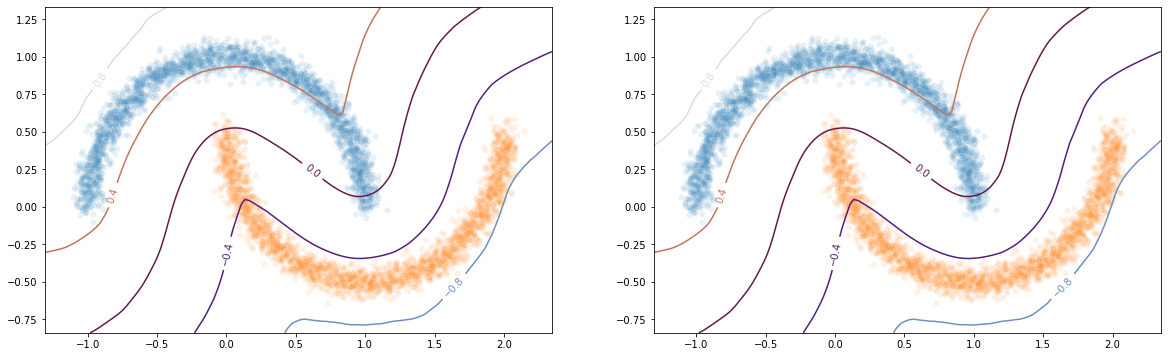

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 120)
y = np.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 120)
xx, yy = np.meshgrid(x, y, sparse=False)
X_pred = np.stack((xx.ravel(), yy.ravel()), axis=1)

# Make predictions from F:
Y_pred = wass(torch.tensor(X_pred).float().to(device))
Y_pred = Y_pred.reshape(x.shape[0], y.shape[0]).detach().cpu().numpy()

# We are also going to check the exported version:
vwass = wass.vanilla_export()
Y_predv = vwass(torch.tensor(X_pred).float().to(device))
Y_predv = Y_predv.reshape(x.shape[0], y.shape[0]).detach().cpu().numpy()

# Plot the results:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(x=X[Y == 1, 0], y=X[Y == 1, 1], alpha=0.1, ax=ax1)
sns.scatterplot(x=X[Y == -1, 0], y=X[Y == -1, 1], alpha=0.1, ax=ax1)
cset = ax1.contour(xx, yy, Y_pred, cmap="twilight", levels=np.arange(-1.2, 1.2, 0.4))
ax1.clabel(cset, inline=1, fontsize=10)

sns.scatterplot(x=X[Y == 1, 0], y=X[Y == 1, 1], alpha=0.1, ax=ax2)
sns.scatterplot(x=X[Y == -1, 0], y=X[Y == -1, 1], alpha=0.1, ax=ax2)
cset = ax2.contour(xx, yy, Y_predv, cmap="twilight", levels=np.arange(-1.2, 1.2, 0.4))
ax2.clabel(cset, inline=1, fontsize=10)

The `vanilla_export()` method allows us to obtain a `torch` module without the overhead from the 1-Lipschitz constraints after training.

<div class="alert alert-block alert-danger"></div>